In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["HF_ENDPOINT"]="https://hf-mirror.com"
from datasets import load_from_disk
import torch.nn as nn, torch.nn.functional as F
import torch, json
from transformers import BertTokenizer, BertModel
from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import pickle

class Pooler(nn.Module):
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        self.proj.load_state_dict(torch.load(pretrained_proj))
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        pooled_output = hidden_states[:, 0]
        pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
        return pooled_output
    
model = BertModel.from_pretrained('../ckpt/cell_bert')
model.pooler = Pooler(model.config, pretrained_proj='../ckpt/cell_proj.bin', proj_dim=256)
proj = model.pooler.proj
# model = model.module
model = model.to("cuda")

# text_pretrained_model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
# tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
tokenizer = BertTokenizer.from_pretrained("../tokenizer/BiomedBERT")
tokenizer.add_special_tokens({'bos_token':'[DEC]'})
tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})       
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  
text_encoder = MedBertModel.from_pretrained('../ckpt/text_bert', add_pooling_layer=True)
text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj='../ckpt/text_proj.bin', proj_dim=256)
text_encoder = text_encoder.to("cuda")

ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
ctm_head.load_state_dict(torch.load('../ckpt/ctm_head.bin'))
ctm_head = ctm_head.to("cuda")

Some weights of BertModel were not initialized from the model checkpoint at ../ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def text_encode(text):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    text = text_encoder(**text).pooler_output
    # text = F.normalize(model.text_projector(text))
    return text

def cell_encode(cell_input_ids, cell_atts):
    cell = model(cell_input_ids.to("cuda"), cell_atts.to("cuda"))
    cell_last_h = cell.last_hidden_state
    cell_pooler = cell.pooler_output
    return cell_last_h, cell_pooler

def ctm(text, cell_emb, cell_atts):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    output = text_encoder(**text,
                encoder_hidden_states = cell_emb.to("cuda"),
                encoder_attention_mask = cell_atts.to("cuda"),
                return_dict = True,
                mode = 'multimodal',
                )
    logits = ctm_head(output.last_hidden_state[:, 0, :])
    logits = F.softmax(logits, dim=-1)[..., 1] # [n]
    return logits

### Load data

In [4]:
import scanpy
data = scanpy.read_h5ad("../data/test/MS_CSF.h5ad")
data

AnnData object with n_obs × n_vars = 65326 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

In [5]:
data.obs

,labels,MS,CSF,valid_clusters,CD4_labels
0,Gran,False,True,True,-1
1,CD4,False,True,True,6
2,CD4,False,True,True,1
3,ncMono,False,True,True,-1
4,CD4,False,True,True,2
...,...,...,...,...,...
65321,RBC,False,False,False,-1
65322,CD8a,False,False,True,-1
65323,RBC,False,False,False,-1
65324,CD8n,False,False,True,-1


In [7]:
data.var

""
FO538757.2
AP006222.2
RP11-206L10.9
FAM41C
NOC2L
...
MT-ND6
MT-CYB
AL592183.1
AC004556.1


In [31]:
import pickle
gene_name2id = pickle.load(open("/data2/zhuyiheng/.conda/envs/metatrans/lib/python3.7/site-packages/geneformer/gene_name_id_dict.pkl", "rb"))

In [34]:
data.var["gene_name"] = data.var.index
data.var = data.var.reset_index(drop=True)
data.var

,gene_name
0,FO538757.2
1,AP006222.2
2,RP11-206L10.9
3,FAM41C
4,NOC2L
...,...
10261,MT-ND6
10262,MT-CYB
10263,AL592183.1
10264,AC004556.1


In [35]:
data.var["feature_id"] = [gene_name2id.get(name, None) for name in data.var["gene_name"]]
data.var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10266 entries, 0 to 10265
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gene_name   10266 non-null  object
 1   feature_id  9390 non-null   object
dtypes: object(2)
memory usage: 160.5+ KB


In [3]:
labels = data.obs["labels"].unique()
labels

['Gran', 'CD4', 'ncMono', 'Tdg', 'CD8a', ..., 'plasma', 'doublet', 'contamination1', 'RBC', 'MegaK']
Length: 22
Categories (22, object): ['B1', 'B2', 'B cell doublets', 'CD4', ..., 'mDC2', 'ncMono', 'pDC', 'plasma']

In [5]:
dataset = load_from_disk("../data/test/tokenized_dataset")
dataset_sub = dataset.shuffle(seed=42)#.select(range(1000))
for label_name in ["celltype", "cell_type", "str_labels", "labels"]:
    if label_name in dataset_sub.column_names:
        break
if label_name != "celltype":
    dataset_sub = dataset_sub.rename_column(label_name,"celltype")

In [6]:
dataset_sub

Dataset({
    features: ['input_ids', 'celltype', 'MS', 'CSF', 'valid_clusters', 'CD4_labels', 'n_counts', 'length'],
    num_rows: 65326
})

In [7]:
print(set(dataset_sub['celltype']))

{'NK2', 'CD4', 'pDC', 'ncMono', 'mDC1', 'Gran', 'Mono', 'plasma', 'Tregs', 'MegaK', 'B2', 'NK1', 'contamination1', 'B1', 'CD8n', 'RBC', 'CD8a', 'Mono Doublet', 'Tdg', 'doublet', 'B cell doublets', 'mDC2'}


In [8]:
df = pd.read_excel("../data/test/type2text.xlsx", sheet_name="Sheet1")  
df.index = df.name
df

,id,name,def
name,,,
NK2,0,NK2,natural killer cell. a lymphocyte that can spo...
NK1,1,NK1,natural killer cell. a lymphocyte that can spo...
MegaK,2,MegaK,megakaryocyte. a large hematopoietic cell (50 ...
B1,3,B1,b1 b cell. a b cell of distinct lineage and su...
B2,4,B2,b2 b cell. a conventional b cell subject to an...
mDC1,5,mDC1,"conventional dendritic cell (cDC), previously ..."
mDC2,6,mDC2,"conventional dendritic cell (cDC), previously ..."
pDC,7,pDC,"plasmacytoid dendritic cell, alse called type ..."
CD4,8,CD4,"cd4-positive, alpha-beta t cell. a mature alph..."


In [9]:
type2text = df.to_dict(orient="dict")["def"]
type2text

{'NK2': 'natural killer cell. a lymphocyte that can spontaneously kill a variety of target cells without prior antigenic activation via germline encoded activation receptors and also regulate immune responses via cytokine release and direct contact with other cells. this cell type is capable of mediating th2 cytokine responses and produce large amounts of th2 cytokines such as il5, il6 and il13. ',
 'NK1': 'natural killer cell. a lymphocyte that can spontaneously kill a variety of target cells without prior antigenic activation via germline encoded activation receptors and also regulate immune responses via cytokine release and direct contact with other cells. this cell type is capable of mediating th1 cytokine responses and produce large amounts of th1 cytokines such as IFN-γ, which activate macrophages and promote cell-mediated immunity.',
 'MegaK': 'megakaryocyte. a large hematopoietic cell (50 to 100 micron) with a lobated nucleus. once mature, this cell undergoes multiple rounds o

In [6]:
type2text = pickle.load(open("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.ontology.def.pkl", "rb"))

In [7]:
texts = [v for v in type2text.values()]
texts

['A material entity of anatomical origin (part of or deriving from an organism) that has as its parts a maximally connected cell compartment surrounded by a plasma membrane.',
 'A cultured cell that is freshly isolated from a organismal source, or derives in culture from such a cell prior to the culture being passaged.',
 'OBSOLETE: A cell line cell that is expected to be capable of an unlimited number of divisions, and is thus able to support indefinite growth/propagation in vitro as part of a immortal cell line.',
 "OBSOLETE. A cell that is found in a natural setting, which includes multicellular organism cells 'in vivo' (i.e. part of an organism), and unicellular organisms 'in environment' (i.e. part of a natural environment).",
 'OBSOLETE: A classification of cells by the organisms within which they are contained.',
 'Any fibroblast that is derived from the neural crest.',
 'Any sensory receptor cell that is a(n) neuron and is capable of some detection of stimulus involved in senso

In [8]:
type2num = dict([(type, i) for i, type in enumerate(type2text.keys())])
type2num

{'CL:0000000': 0,
 'CL:0000001': 1,
 'CL:0000002': 2,
 'CL:0000003': 3,
 'CL:0000004': 4,
 'CL:0000005': 5,
 'CL:0000006': 6,
 'CL:0000007': 7,
 'CL:0000008': 8,
 'CL:0000009': 9,
 'CL:0000010': 10,
 'CL:0000011': 11,
 'CL:0000012': 12,
 'CL:0000013': 13,
 'CL:0000014': 14,
 'CL:0000015': 15,
 'CL:0000016': 16,
 'CL:0000017': 17,
 'CL:0000018': 18,
 'CL:0000019': 19,
 'CL:0000020': 20,
 'CL:0000021': 21,
 'CL:0000022': 22,
 'CL:0000023': 23,
 'CL:0000024': 24,
 'CL:0000025': 25,
 'CL:0000026': 26,
 'CL:0000027': 27,
 'CL:0000028': 28,
 'CL:0000029': 29,
 'CL:0000030': 30,
 'CL:0000031': 31,
 'CL:0000032': 32,
 'CL:0000033': 33,
 'CL:0000034': 34,
 'CL:0000035': 35,
 'CL:0000036': 36,
 'CL:0000037': 37,
 'CL:0000038': 38,
 'CL:0000039': 39,
 'CL:0000040': 40,
 'CL:0000041': 41,
 'CL:0000042': 42,
 'CL:0000043': 43,
 'CL:0000045': 44,
 'CL:0000046': 45,
 'CL:0000047': 46,
 'CL:0000048': 47,
 'CL:0000049': 48,
 'CL:0000050': 49,
 'CL:0000051': 50,
 'CL:0000052': 51,
 'CL:0000054': 52,
 'C

In [12]:
# import json
# types = list(set(dataset_sub['celltype']))
# type2text = json.load(open('data/type2text.json'))
# texts = [type2text[typename] for typename in types]
with torch.no_grad():
    text_embs = torch.cat([text_encode(text) for text in texts], 0).T.cuda() # 256 * N
text_embs.requires_grad = False

In [18]:
f = open("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.ontology.langcell.emb", "w")
for i, key in enumerate(type2text.keys()):
    f.write(f"{key}\t")
    embs = text_embs[:, i]
    for emb in embs[:-1]:
        f.write(f"{emb}\t")
    f.write(f"{embs[-1]}\n")

In [ ]:
celltype_map = np.array([type2num.get(example["celltype"], -1) for example in dataset_sub])

In [15]:
dataset_sub = dataset_sub.select(np.where(celltype_map!=(-1))[0])
dataset_sub

Dataset({
    features: ['input_ids', 'celltype', 'MS', 'CSF', 'valid_clusters', 'CD4_labels', 'n_counts', 'length'],
    num_rows: 51179
})

In [16]:
def classes_to_ids(example):
    example["label"] = type2num[example["celltype"]]
    return example
testdataset = dataset_sub.map(classes_to_ids, num_proc=16)
remove_columns = testdataset.column_names
remove_columns.remove('input_ids')
remove_columns.remove('label')

testdataset = testdataset.remove_columns(remove_columns)
batchsize = 32
collator = DataCollatorForCellClassification()
dataloader = DataLoader(testdataset, batch_size=batchsize, collate_fn=collator, shuffle=False)

Map (num_proc=16):   0%|          | 0/51179 [00:00<?, ? examples/s]

In [22]:
cell_embs = torch.zeros(len(dataset_sub), 256)
model.eval()
text_encoder.eval()
preds = torch.zeros(len(dataset_sub))
sim_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
ctm_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])
labels = torch.tensor(testdataset['label'])
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader)):
        cell_last_h, cellemb = cell_encode(d['input_ids'], d['attention_mask']) # batchsize * 256
        sim = (cellemb @ text_embs) / 0.05 # batchsize * 161
        sim_logit = F.softmax(sim, dim=-1)

        # ctm
        ctm_logit = torch.zeros_like(sim_logit)
        for text_idx, text in enumerate(texts):
            text_list = [text] * sim_logit.shape[0]
            ctm_logit[:, text_idx] = ctm(text_list, cell_last_h, d['attention_mask'])
        ctm_logit = F.softmax(ctm_logit, dim=-1)

        logit = (sim_logit + ctm_logit) / 2
        pred = logit.argmax(dim=-1)
        sim_logits[i * batchsize: (i + 1) * batchsize] = sim_logit.cpu()
        ctm_logits[i * batchsize: (i + 1) * batchsize] = ctm_logit.cpu()
        logits[i * batchsize: (i + 1) * batchsize] = logit.cpu()
        cell_embs[i * batchsize: (i + 1) * batchsize] = cellemb.cpu()
        preds[i * batchsize: (i + 1) * batchsize] = pred.cpu()

# torch.save({'cell_embs': cell_embs,
#             'sim_logits': sim_logits, 'ctm_logits': ctm_logits, 
#             'preds': preds, 'labels': labels, 'logits': logits}, 
#            'data/results.pt')

0it [00:00, ?it/s]/data2/zhuyiheng/.conda/envs/metatrans/lib/python3.7/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
1600it [1:02:04,  2.33s/it]


In [23]:
# %%
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import numpy as np
sim_preds = sim_logits.argmax(dim=-1)
ctm_preds = ctm_logits.argmax(dim=-1)
alpha = 0.1
preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)
labels = torch.tensor(testdataset['label'])
for row in confusion_matrix(labels, preds):
    print('\t'.join([str(x) for x in row]))
print(classification_report(labels, preds, digits=4))

104	476	23	0	0	0	0	21	15	34	6
16	3692	1	0	0	0	1	0	3	30	0
0	0	113	0	0	0	0	0	0	0	0
0	1	5	2484	197	2	0	0	1	0	3
1	3	1	1101	65	0	2	3	2	0	13
0	1	2	0	0	66	6	11	0	0	0
1	10	17	0	0	874	6	63	0	0	0
3	3	4	0	0	25	0	299	0	1	0
54	34	29	1	1	0	0	2	18988	1416	4580
50	1383	9	1	1	0	0	0	2125	8845	560
2	0	10	0	2	0	0	2	1794	83	1396
              precision    recall  f1-score   support

           0     0.4502    0.1532    0.2286       679
           1     0.6589    0.9864    0.7901      3743
           2     0.5280    1.0000    0.6911       113
           3     0.6925    0.9224    0.7911      2693
           4     0.2444    0.0546    0.0892      1191
           5     0.0683    0.7674    0.1254        86
           6     0.4000    0.0062    0.0122       971
           7     0.7456    0.8925    0.8125       335
           8     0.8282    0.7563    0.7906     25105
           9     0.8497    0.6817    0.7565     12974
          10     0.2129    0.4244    0.2835      3289

    accuracy                         0.7

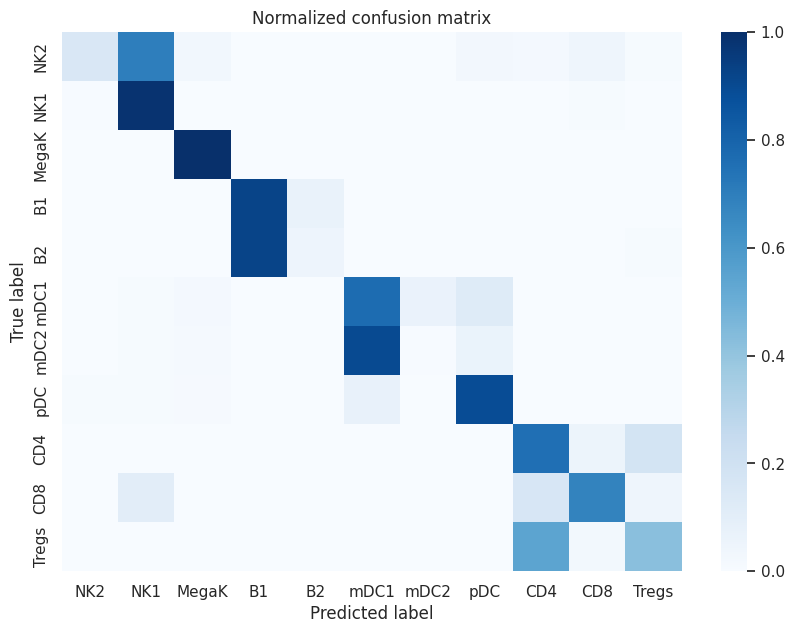

In [30]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=False, cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(labels, preds, type2text.keys(), normalize=True)

In [ ]:
import anndata as ad, scanpy as sc
cell_embs_ad = ad.AnnData(cell_embs.numpy())
cell_embs_ad.obs['celltype'] = dataset_sub['celltype']
if 'batch' in dataset_sub.features.keys():
    cell_embs_ad.obs['batch'] = dataset_sub['batch']
    cell_embs_ad.obs['batch'] = cell_embs_ad.obs['batch'].astype(str)
cell_embs_ad.obs['predictions'] = [types[i] for i in preds]
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=80)

In [ ]:
sc.tl.umap(cell_embs_ad)
sc.pl.umap(cell_embs_ad, color=['celltype', 'predictions', 'batch'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

It is evident that the cell embeddings generated directly by LangCell, without any fine-tuning, possess desirable properties: they cluster by cell type and eliminate batch effects. By comparing the left and middle plots, one can intuitively observe that LangCell is capable of reliably annotating cell types in a zero-shot scenario.
